In [1]:
import oracledb
import pandas as pd

Make sure to to login the terminal with:
```bash
ssh -l username -L localhost:1522:dbhost.students.cs.ubc.ca:1522 remote.students.cs.ubc.ca
```

And make sure to replace `cwl` and `snum` with the respective answers

In [5]:
# CWL and student number
cwl = "pushya"
snum = "47953062"

# Connect to Oracle DB
dsn = oracledb.makedsn("localhost", 1522, service_name="stu")
connection = oracledb.connect(user=f"ora_{cwl}", password=f"a{snum}", dsn=dsn)

# Create cursor
cur = connection.cursor()

cur.execute("""
        SELECT tp.race, AVG(tp.percent_yes) AS avg_telehealth_usage
        FROM telemedicineprovider tp
        GROUP BY tp.race
        """)
race_df = pd.DataFrame(cur.fetchall(), columns=["race", "avg_telehealth_usage"])

# 2. Urban vs rural telehealth adoption
cur.execute("""
SELECT 
  tp.urbanization,
  AVG(tp.percent_yes) AS avg_telehealth_usage
FROM telemedicineprovider tp
GROUP BY tp.urbanization
""")
urban_df = pd.DataFrame(cur.fetchall(), columns=["urbanization", "avg_telehealth_usage"])

# 3. Education level effect on telehealth usage
cur.execute("""
SELECT 
  tp.education,
  AVG(tp.percent_yes) AS avg_telehealth_usage
FROM telemedicineprovider tp
GROUP BY tp.education
""")
edu_df = pd.DataFrame(cur.fetchall(), columns=["education", "avg_telehealth_usage"])

# 4. Combined urbanization and beneficiary data
cur.execute("""
SELECT 
  tp.urbanization,
  AVG(tp.percent_yes) AS avg_telehealth_usage,
  SUM(bd.total_bene_telehealth) AS total_bene_telehealth
FROM telemedicineprovider tp
JOIN (
  SELECT urbanization, SUM(total_bene_telehealth) AS total_bene_telehealth
  FROM beneficiarydata
  GROUP BY urbanization
) bd
  ON tp.urbanization = bd.urbanization
WHERE tp.indicator = 'Scheduled one or more telemedicine appointments'
  AND tp.percent_yes IS NOT NULL
GROUP BY tp.urbanization, bd.total_bene_telehealth
""")

urban_combo_df = pd.DataFrame(
    cur.fetchall(), 
    columns=["urbanization", "avg_telehealth_usage", "total_bene_telehealth"]
)

# Load into pandas DataFrames
# race_df = pd.read_sql(race_query, con=connection)
# urban_df = pd.read_sql(urban_query, con=connection)
# edu_df = pd.read_sql(edu_query, con=connection)
# urban_combo_df = pd.read_sql(urban_combo_query, con=connection)

# Close cursor and connection
cur.close()
connection.close()

# Display outputs
print("Race:\n", race_df, "\n")
print("Urbanization:\n", urban_df, "\n")
print("Education:\n", edu_df, "\n")
print("Urbanization + Medicare:\n", urban_combo_df)

Race:
                  race  avg_telehealth_usage
0  Black non-Hispanic             27.733333
1            Hispanic             22.877778
2  White non-Hispanic             24.255556
3  Other non-Hispanic             23.846667 

Urbanization:
   urbanization  avg_telehealth_usage
0        Urban             24.811111
1        Rural             21.166667
2      Unknown             24.687037 

Education:
             education  avg_telehealth_usage
0             college             25.311111
1  highschool or less             22.388889
2             Unknown             24.168889
3   bachelor or above             25.555556 

Urbanization + Medicare:
   urbanization  avg_telehealth_usage  total_bene_telehealth
0        Urban             22.433333              216895932
1      Unknown             22.400000                      0
2        Rural             18.566667               48255942


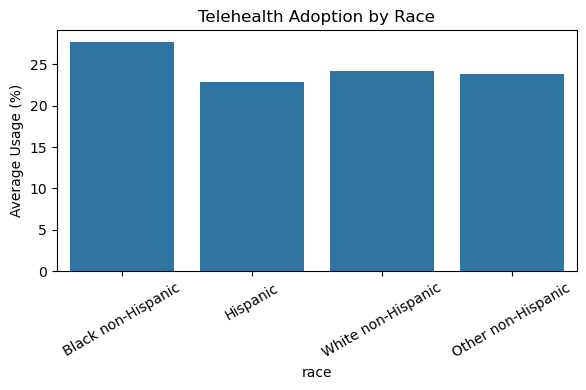

                 race  avg_telehealth_usage
0  Black non-Hispanic             27.733333
1            Hispanic             22.877778
2  White non-Hispanic             24.255556
3  Other non-Hispanic             23.846667


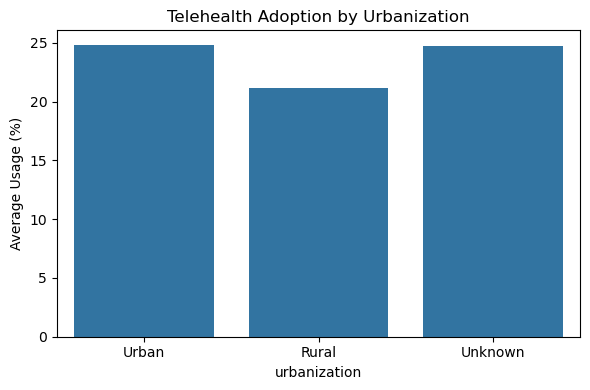

  urbanization  avg_telehealth_usage
0        Urban             24.811111
1        Rural             21.166667
2      Unknown             24.687037


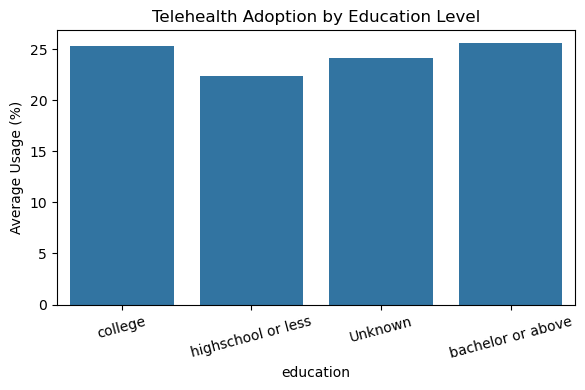

            education  avg_telehealth_usage
0             college             25.311111
1  highschool or less             22.388889
2             Unknown             24.168889
3   bachelor or above             25.555556


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, ttest_ind


# Plot 1: Race
plt.figure(figsize=(6, 4))
sns.barplot(x="race", y="avg_telehealth_usage", data=race_df)
plt.title("Telehealth Adoption by Race")
plt.ylabel("Average Usage (%)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

print(race_df)


# Plot 2: Urbanization
plt.figure(figsize=(6, 4))
sns.barplot(x="urbanization", y="avg_telehealth_usage", data=urban_df)
plt.title("Telehealth Adoption by Urbanization")
plt.ylabel("Average Usage (%)")
plt.tight_layout()
plt.show()

print(urban_df)

# Plot 3: Education
plt.figure(figsize=(6, 4))
sns.barplot(x="education", y="avg_telehealth_usage", data=edu_df)
plt.title("Telehealth Adoption by Education Level")
plt.ylabel("Average Usage (%)")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

print(edu_df)


In [7]:
import pandas as pd
from scipy.stats import norm


df = pd.read_csv("Access_and_telemedicine_use_COVID19_CLEAN.csv")

# Filter the relevant indicator (actual telehealth use)
df_filtered = df[
    (df["indicator"] == "Scheduled one or more telemedicine appointments") &
    (df["race"].notna()) &
    (df["percent_yes"].notna()) &
    (df["standarderror_yes"].notna())
]

# Group by race: average percent & standard error
grouped = df_filtered.groupby("race").agg({
    "percent_yes": "mean",
    "standarderror_yes": "mean"
}).reset_index()

# 2020 US Census: Proportion of population by race
population_props = {
    "White non-Hispanic": 0.616,
    "Hispanic": 0.189,
    "Black non-Hispanic": 0.124,
    "Other non-Hispanic": 0.071
}
grouped["pop_proportion"] = grouped["race"].map(population_props)

# Run z-tests
results = []
for _, row in grouped.iterrows():
    if pd.notnull(row["pop_proportion"]):
        p_hat = row["percent_yes"] / 100
        p_0 = row["pop_proportion"]
        se = row["standarderror_yes"] / 100
        z = (p_hat - p_0) / se
        p_value = 2 * (1 - norm.cdf(abs(z)))
        results.append({
            "race": row["race"],
            "telehealth_rate (%)": round(p_hat * 100, 2),
            "population_share (%)": round(p_0 * 100, 2),
            "standard_error (%)": round(se * 100, 3),
            "z_score": round(z, 3),
            "p_value": round(p_value, 4),
            "significant (α=0.05)": p_value < 0.05
        })

# Output results
result_df = pd.DataFrame(results)
print(result_df.to_string(index=False))

              race  telehealth_rate (%)  population_share (%)  standard_error (%)  z_score  p_value  significant (α=0.05)
Black non-Hispanic                26.00                  12.4               2.567    5.299   0.0000                  True
          Hispanic                20.27                  18.9               2.200    0.621   0.5345                 False
Other non-Hispanic                21.43                   7.1               1.427   10.047   0.0000                  True
White non-Hispanic                21.97                  61.6               1.200  -33.028   0.0000                  True
